# Transforms Manager

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Export

#Internal dependencies
from exp.nb_AudioCommon import * 
from exp.nb_DataAugmentation import * 
from exp.nb_FastWidgets import * 

## Common Functions 

In [3]:
#Export
TfmsGroups = [TfmList]

In [4]:
#Export
def flatten(x, flattenStrings=False):
    '''Transforms [[x]] in [x]'''
    if not flattenStrings:
        if isinstance(x,str):
            return [x]
    if isinstance(x, collections.Iterable):
        return [a for i in x for a in flatten(i)]
    else:
        return [x]

In [5]:
def test_flatten():
    A=[[1,2],[3,4,5]]
    assert [1,2,3,4,5] == flatten(A)
    
    B = [A]
    assert [1,2,3,4,5] == flatten(B)

    C = [[1,2],3,[4,5]]
    assert [1,2,3,4,5] == flatten(C)
    
    print('DONE')

test_flatten()

DONE


In [6]:
def test_flatten_with_string():
    A='abcd'
    assert ['abcd'] == flatten(A)

    B=['ab','cd']
    assert ['ab','cd'] == flatten(B)

    C=[['hello'],' ',['world']]
    assert ['hello',' ','world'] == flatten(C)

    print('DONE')
    
test_flatten_with_string()

DONE


In [7]:
#Export
def getTfmList(g:TfmsGroups, up_to_grpup=None)->TfmList:
    '''Returns transformations up to specified group included'''
    grps = g if up_to_grpup is None else [x for i,x in enumerate(g) if i<=up_to_grpup] 
    ret = flatten(grps)
    ret = [t for t in ret if []!=t] # filter none
    return ret

In [8]:
def test_getTfmList():
    g = [[torchaudio.transforms.Scale, torchaudio.transforms.PadTrim],[torchaudio.transforms.MEL]]
    assert 3==len(getTfmList(g))
    assert 2==len(getTfmList(g,0))
    assert 3==len(getTfmList(g,1))
    print('DONE')
    
test_getTfmList()

DONE


In [9]:
#Export
def applyTfms(tfms:TfmList, x):
    '''Apply a list of transformations'''
    ret = x
    for tfm in tfms:
        ret = tfm(ret)
    return ret

In [10]:
#Export
def removeFirstTfmsByType(tfmsArr, name:str):
    ret = tfmsArr.copy()
    for i,t in enumerate(ret):
        if t.__name__==name:
            del ret[i]
            return (ret,t)
    return tfmsArr,None

In [11]:
def test_removeFirstTfmsByType():
    tfms = get_transforms()
    tfmsArr = tfms[0]
    tfmsArrRet, found = removeFirstTfmsByType(tfmsArr,'crop_pad')
    assert found is not None
    assert len(tfmsArr)==(len(tfmsArrRet)+1)
    print('DONE')
    
test_removeFirstTfmsByType()

DONE


In [18]:
#Export
def sortByTfmOrderAttr(arr):
    return sorted(arr, key=getTfmOrder)

In [21]:
def test_sortByTfmOrderAttr():
    tfms = get_transforms()
    arr = tfms[0]
    srt = sortByTfmOrderAttr(arr)
    assert len(srt) == len(arr)
    srtIds = [getTfmOrder(t) for t in sorted]
    for i in range(len(srtIds)-1):
        assert srtIds[i]<=srtIds[i+1]
    
    print('Before sort')
    for t in arr:
        print(getTfmOrder(t), str(t)[:30] + '...')
        
    print('After sort')
    for t in srt:
        print(getTfmOrder(t), str(t)[:30] + '...')
        
    
test_sortByTfmOrderAttr()

Before sort
99 RandTransform(tfm=TfmCrop (cro...
10 RandTransform(tfm=TfmPixel (fl...
4 RandTransform(tfm=TfmCoord (sy...
5 RandTransform(tfm=TfmAffine (r...
5 RandTransform(tfm=TfmAffine (z...
8 RandTransform(tfm=TfmLighting ...
8 RandTransform(tfm=TfmLighting ...
After sort
4 RandTransform(tfm=TfmCoord (sy...
5 RandTransform(tfm=TfmAffine (r...
5 RandTransform(tfm=TfmAffine (z...
8 RandTransform(tfm=TfmLighting ...
8 RandTransform(tfm=TfmLighting ...
10 RandTransform(tfm=TfmPixel (fl...
99 RandTransform(tfm=TfmCrop (cro...


## Transformations Manager

In all the situation where there are complex transformtations (ie: an augmented sound that becomes a spectrogram image), TfmsManager can help you to **group transformations into meaningful groups that can be easily tested separately**.
Once you've completed the fine tuning step of each group of transformations, **get_tfms()** consolidate your work and generates the final transform list compatible with fast.ai.

For example:
* IMAGE: bot for train and valid we have a *PRE* "crop_pad" transformation (that is not considered Data augmentation).
* SOUND: no *PRE* transformation but between the data augmentation and post processing there is a "SIZE" transformation that ensure that the spectrogram is computed on the minimal required size, saving precious computing resources.

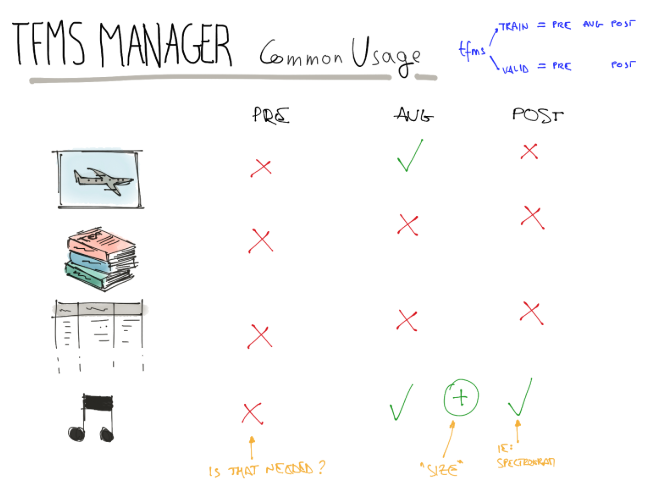

In [12]:
#Export
class TfmsManager:
    def __init__(self, train_tfms_groups:TfmsGroups, valid_tfms_groups:TfmsGroups):
        self.train_tfmsg, self.valid_tfmsg = listify(train_tfms_groups), listify(valid_tfms_groups)
    
    def get_tfms(self)->[TfmList,TfmList]:
        return [self.get_train_tfms(up_to_grpup=None), self.get_valid_tfms(up_to_grpup=None)]

#Training set functions
    def get_train_tfms(self, up_to_grpup=None)->TfmList:
        return getTfmList(self.train_tfmsg,up_to_grpup)    
        
    def apply_train_tfms(self, x, up_to_grpup=None):
        return applyTfms(self.get_train_tfms(up_to_grpup),x)
    
#Validation set functions 
    def get_valid_tfms(self, up_to_grpup=None)->TfmList:
        return getTfmList(self.valid_tfmsg,up_to_grpup)

    def apply_valid_tfms(self, x, up_to_grpup=None):
        return applyTfms(self.get_train_tfms(up_to_grpup),x)

**IMPORTANT**: to use TfmsManager with fast.ai use:

```python
tm = TfmsManager.create_from_main_groups(...)

tfms = tm.get_tfms() # THIS ROW ADAPT THE TRANSFORMATIONS TO fast.ai

data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch
```

# Export

In [13]:
!python notebook2script.py TransformsManager.ipynb

Converted TransformsManager.ipynb to nb_TransformsManager.py
